# Writing custom dataset for A-Z Handwritten Data

In [1]:
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset

In [2]:
class HandwrittenAZDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: torchvision.transforms = None):
        self.dataframe = df
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape((28, 28, 1))
        label = self.dataframe.iloc[idx, 0] + 10
        if self.transform:
            image = self.transform(image)

        return image, label

# Combining datasets and create data loaders for training

## Dependencies

In [3]:
from typing import Tuple
from typing import List

from sklearn.model_selection import train_test_split

from torchvision import datasets

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset

from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import ToPILImage
from torchvision.transforms import Resize
from torchvision.transforms import Normalize

## Combine the two datasets

In [4]:
def loading_data(
        root: str = r"D:\UsingSpace\Programing Languages Learning\Python Programing\HCMUTE Projects\Practical Python "
                    r"Programming\Final Project\dataset\data",
        csv_file: str = r"D:\UsingSpace\Programing Languages Learning\Python Programing\HCMUTE Projects\Practical "
                        r"Python Programming\Final Project\dataset\data\A_Z Handwritten Data.csv"
) -> Tuple[Dataset, Dataset]:

    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize((0.5,), (0.5,))
    ])

    train_data = datasets.MNIST(
        root=root,
        train=True,
        download=True,
        transform=transform,
        target_transform=None
    )

    test_data = datasets.MNIST(
        root=root,
        train=False,
        download=True,
        transform=transform,
        target_transform=None
    )

    az_data = pd.read_csv(csv_file)

    train_df, test_df = train_test_split(az_data, test_size=0.2, random_state=42)

    transform = Compose([
        ToPILImage(),
        Resize((224, 224)),
        ToTensor(),
        Normalize((0.5,), (0.5,))
    ])

    train_az = HandwrittenAZDataset(
        df=train_df,
        transform=transform
    )

    test_az = HandwrittenAZDataset(
        df=test_df,
        transform=transform
    )

    combined_train_dataset = ConcatDataset([train_data, train_az])
    combined_test_dataset = ConcatDataset([test_data, test_az])

    return combined_train_dataset, combined_test_dataset

## Create data loaders

In [5]:
def data_loader(batch_size: int = 32) -> Tuple[DataLoader, DataLoader]:
    train_data, test_data = loading_data()

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4
    )

    return train_loader, test_loader

# Define model

In [6]:
from torch import nn

## Create Residual Block

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 stride: int = 1,
                 down_sample: nn.Module | None = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
        )
        self.down_sample = down_sample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.down_sample:
            residual = self.down_sample(x)
        out += residual
        out = self.relu(out)

        return out

## Create ResNet Model

In [8]:
class ResNet(nn.Module):
    def __init__(self, in_channels: int,
                 layers: List[int],
                 num_classes: int,
                 block=ResidualBlock,
                 in_planes: int = 64):
        super(ResNet, self).__init__()

        self.in_planes = in_planes
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=self.in_planes,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False
            ),
            nn.BatchNorm2d(self.in_planes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer0 = self._make_layer(block, self.in_planes, layers[0], stride=1)
        self.layer1 = self._make_layer(block, self.in_planes * 2, layers[1], stride=2)
        self.layer2 = self._make_layer(block, self.in_planes * 4, layers[2], stride=2)
        self.layer3 = self._make_layer(block, self.in_planes, layers[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def _make_layer(self, block, planes, blocks, stride: int = 1):
        down_sample = None
        if stride != 1 or self.in_planes != planes:
            down_sample = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.in_planes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes)
            )
        layers = list()
        layers.append(block(self.in_planes, planes, stride, down_sample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Train model using PyTorch

In [9]:
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.emit_nvtx(False)

In [10]:
def accuracy_fn(y_predict: torch.Tensor, y_true: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_predict).sum().item()
    acc = correct * 100 / len(y_true)
    return acc

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
model = ResNet(
    in_channels=1,
    layers=[3, 4, 6, 3],
    num_classes=36 # 10 digits and 26 letters
).to(device)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
loss_fn = nn.CrossEntropyLoss()

## Train function

In [14]:
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

from typing import Any

In [15]:
def train(data_loader: DataLoader,
          model: nn.Module,
          device: torch.device,
          loss_fn: Any,
          accuracy_fn: Any,
          optimizer: torch.optim) -> Tuple[float, torch.tensor]:
    model.to(device)
    model.train()

    train_loss = train_acc = 0

    # scaler = GradScaler()

    for batch, (X, y) in enumerate(data_loader):

        optimizer.zero_grad()
        # for param in model.parameters():
        #     param.grad = None

        X, y = X.to(device), y.to(device)

        # with autocast():
        y_logit = model(X)
        y_predict = torch.softmax(y_logit, dim=1).argmax(dim=1)

        loss = loss_fn(y_logit, y)
        acc = accuracy_fn(y_predict, y)

        train_loss += loss
        train_acc += acc

        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Training batch: {batch}/{len(data_loader)}")

    train_acc /= len(data_loader)
    train_loss /= len(data_loader)

    return train_acc, train_loss

## Validating function

In [16]:
def validate(data_loader: DataLoader,
             model: nn.Module,
             device: torch.device,
             loss_fn: Any,
             accuracy_fn: Any
             ) -> Tuple[float, torch.tensor]:
    model.to(device)
    model.eval()

    test_loss = test_acc = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            y_logit = model(X)
            y_predict = torch.softmax(y_logit, dim=1).argmax(dim=1)

            test_loss += loss_fn(y_logit, y)
            test_acc += accuracy_fn(y_predict, y)

            if batch % 500 == 0:
                print(f"Testing batch: {batch}/{len(data_loader)}")

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    return test_acc, test_loss

## Traing process

In [17]:
from tqdm import tqdm

In [18]:
train_loader, test_loader = data_loader(batch_size=32)

In [ ]:
epochs = 7

for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch}/{epochs}")

    train_acc, train_loss = train(
        data_loader=train_loader,
        model=model,
        device=device,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        optimizer=optimizer
    )

    test_acc, test_loss = validate(
        data_loader=test_loader,
        model=model,
        device=device,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    print(f"Train_acc: {train_acc}, Train_loss: {train_loss}")
    print(f"Test_acc: {test_acc}, Test_loss: {test_loss}")

  0%|          | 0/5 [00:00<?, ?it/s]Epoch: 0/5
Training batch: 0/11187
Training batch: 500/11187
Training batch: 1000/11187
Training batch: 1500/11187
Training batch: 2000/11187
Training batch: 2500/11187
Training batch: 3000/11187
Training batch: 3500/11187
Training batch: 4000/11187
Training batch: 4500/11187
Training batch: 5000/11187
Training batch: 5500/11187
Training batch: 6000/11187
Training batch: 6500/11187
Training batch: 7000/11187
Training batch: 7500/11187
Training batch: 8000/11187
Training batch: 8500/11187
Training batch: 9000/11187
Training batch: 9500/11187
Training batch: 10000/11187
Training batch: 10500/11187
Training batch: 11000/11187
Testing batch: 0/2641
Testing batch: 500/2641
Testing batch: 1000/2641
Testing batch: 1500/2641
Testing batch: 2000/2641
Testing batch: 2500/2641
Train_acc: 93.99498301600072, Train_loss: 0.21439795196056366
Test_acc: 96.31294964028777, Test_loss: 0.11195269972085953
Epoch: 1/5
 20%|██        | 1/5 [39:06<2:36:27, 2346.98s/it]Training batch: 0/11187
Training batch: 500/11187
Training batch: 1000/11187
Training batch: 1500/11187
Training batch: 2000/11187
Training batch: 2500/11187
Training batch: 3000/11187
Training batch: 3500/11187
Training batch: 4000/11187
Training batch: 4500/11187
Training batch: 5000/11187
Training batch: 5500/11187
Training batch: 6000/11187
Training batch: 6500/11187
Training batch: 7000/11187
Training batch: 7500/11187
Training batch: 8000/11187
Training batch: 8500/11187
Training batch: 9000/11187
Training batch: 9500/11187
Training batch: 10000/11187
Training batch: 10500/11187
Training batch: 11000/11187
Testing batch: 0/2641
Testing batch: 500/2641
Testing batch: 1000/2641
Testing batch: 1500/2641
Testing batch: 2000/2641
Testing batch: 2500/2641
Train_acc: 98.0647179762224, Train_loss: 0.06620538234710693
Test_acc: 98.54931843998486, Test_loss: 0.05284350365400314
 40%|████      | 2/5 [1:18:09<1:57:13, 2344.48s/it]Epoch: 2/5
Training batch: 0/11187
Training batch: 500/11187
Training batch: 1000/11187
Training batch: 1500/11187
Training batch: 2000/11187
Training batch: 2500/11187
Training batch: 3000/11187
Training batch: 3500/11187
Training batch: 4000/11187
Training batch: 4500/11187
Training batch: 5000/11187
Training batch: 5500/11187
Training batch: 6000/11187
Training batch: 6500/11187
Training batch: 7000/11187
Training batch: 7500/11187
Training batch: 8000/11187
Training batch: 8500/11187
Training batch: 9000/11187
Training batch: 9500/11187
Training batch: 10000/11187
Training batch: 10500/11187
Training batch: 11000/11187
Testing batch: 0/2641
Testing batch: 500/2641
Testing batch: 1000/2641
Testing batch: 1500/2641
Testing batch: 2000/2641
Testing batch: 2500/2641
Train_acc: 98.61111111111111, Train_loss: 0.046906184405088425
Test_acc: 98.31976524043922, Test_loss: 0.05492191016674042
Epoch: 3/5
 60%|██████    | 3/5 [1:57:06<1:18:01, 2340.82s/it]Training batch: 0/11187
Training batch: 500/11187
Training batch: 1000/11187
Training batch: 1500/11187
Training batch: 2000/11187
Training batch: 2500/11187
Training batch: 3000/11187
Training batch: 3500/11187
Training batch: 4000/11187
Training batch: 4500/11187
Training batch: 5000/11187
Training batch: 5500/11187
Training batch: 6000/11187
Training batch: 6500/11187
Training batch: 7000/11187
Training batch: 7500/11187
Training batch: 8000/11187
Training batch: 8500/11187
Training batch: 9000/11187
Training batch: 9500/11187
Training batch: 10000/11187
Training batch: 10500/11187
Training batch: 11000/11187
Testing batch: 0/2641
Testing batch: 500/2641
Testing batch: 1000/2641
Testing batch: 1500/2641
Testing batch: 2000/2641
Testing batch: 2500/2641
Train_acc: 98.94269017609726, Train_loss: 0.0350838303565979
Test_acc: 98.87353275274518, Test_loss: 0.042943213135004044
Epoch: 4/5
 80%|████████  | 4/5 [2:35:55<38:56, 2336.24s/it]  Training batch: 0/11187
Training batch: 500/11187
Training batch: 1000/11187
Training batch: 1500/11187
Training batch: 2000/11187
Training batch: 2500/11187
Training batch: 3000/11187
Training batch: 3500/11187
Training batch: 4000/11187
Training batch: 4500/11187
Training batch: 5000/11187
Training batch: 5500/11187
Training batch: 6000/11187
Training batch: 6500/11187
Training batch: 7000/11187
Training batch: 7500/11187
Training batch: 8000/11187
Training batch: 8500/11187
Training batch: 9000/11187
Training batch: 9500/11187
Training batch: 10000/11187
Training batch: 10500/11187
Training batch: 11000/11187
Testing batch: 0/2641
Testing batch: 500/2641
Testing batch: 1000/2641
Testing batch: 1500/2641
Testing batch: 2000/2641
Testing batch: 2500/2641
Train_acc: 99.15778358809332, Train_loss: 0.027853284031152725
Test_acc: 85.39828663385082, Test_loss: 0.865649402141571
100%|██████████| 5/5 [5:24:50<00:00, 3898.15s/it]

Process finished with exit code 0

# Validate using confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Create a function to get predicted lables

In [20]:
def get_test_predictions(
        data_loader: DataLoader,
        model: nn.Module,
        device: torch.device
) -> torch.Tensor:
    y_predictions = list()

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc='Making decisions'):
            X, y = X.to(device), y.to(device)

            y_logit = model(X)
            y_prediction = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_predictions.append(y_prediction.cpu())

    return torch.cat(y_predictions)

## Create a function to load the labels' names

In [22]:
def get_labels(dataloader: DataLoader) -> List[int]:
    labels = list()

    for _, label in dataloader:
        labels.extend(label.tolist())

    return labels

## Plot the confusion matrix

In [ ]:
y_true = get_labels(test_loader)

y_predictions = get_test_predictions(
    data_loader=test_loader,
    model=model,
    device=device
)

cm = confusion_matrix(
    y_true=y_true,
    y_pred=y_predictions.cpu().detach().numpy(),
)
fig, ax = plt.subplots(figsize=(10, 10))

ConfusionMatrixDisplay(cm, display_labels=label_names).plot(ax=ax)
plt.show()

# Save and load model

## Save model

In [ ]:
torch.save(model.state_dict(), f='artifacts/model.pth')

## Load model

In [ ]:
model = ResNet(
    in_channels=1,
    layers=[3, 4, 6, 3],
    num_classes=len(get_classes())
)

state_dict = torch.load(f"artifacts/model1.pth")
model.load_state_dict(state_dict)

# Plot the predicting result

## Supporting function

In [ ]:
from imutils import build_montages
import cv2

In [ ]:
def plot_vals(dataloader, model, device, label_names):
    images = list()
    side = 10

    for i, (img, label) in enumerate(dataloader):
        if i >= side * side:
            break
        img, label = img.to(device), label.to(device)

        with torch.inference_mode():
            probs = model(img)
            prediction = probs.argmax(dim=1).item()

            label_name = label_names[prediction]

            image = (img.squeeze().cpu().detach().numpy() * 255).astype("uint8")
            color = (0, 255, 0) if prediction == label.item() else (0, 0, 255)

            image = cv2.merge([image] * 3)
            image = cv2.resize(image, (75, 75), interpolation=cv2.INTER_LINEAR)
            cv2.putText(image, label_name, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

            images.append(image)

    montage = build_montages(images, (75, 75), (side, side))[0]

    cv2.imshow("OCR Results", montage)
    cv2.waitKey(0)

In [8]:
import torch

from models.models import ResNet

import cv2

import imutils
from imutils.contours import sort_contours
import numpy as np
import string

import matplotlib.pyplot as plt

In [2]:
image_path = f"images/test1.png"

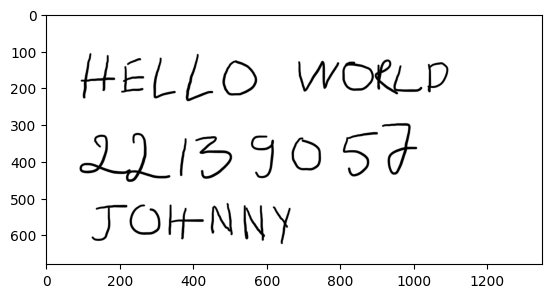

In [9]:
image = cv2.imread(image_path)
plt.imshow(image)

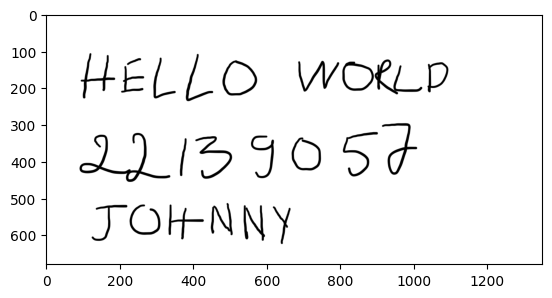

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

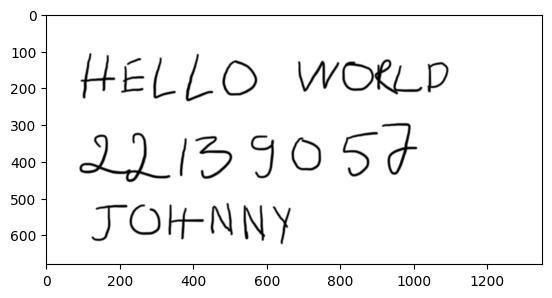

In [16]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

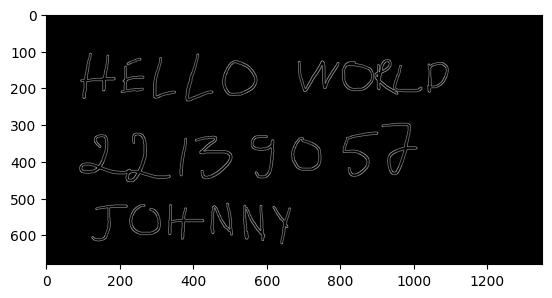

In [15]:
edged = cv2.Canny(blurred, 30, 150)
plt.imshow(edged, cmap='gray')

In [17]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method='left-to-right')[0]